In [1]:
import sys

sys.argv = [""]
del sys

In [2]:
import cv2
import argparse
import numpy as np
import torch
import platform

import matplotlib.pyplot as plt
from torchvision import transforms
from IPython.display import display

In [3]:
from inpaint.data import PlacesDataset
from inpaint.utils import denorm

In [4]:
to_PILImage = transforms.ToPILImage()

In [5]:
def create_cfg(args):
    parser = argparse.ArgumentParser()
    for key, val in args.items():
        parser.add_argument(key, default=val)

    cfg = parser.parse_args()
    return cfg

In [6]:
path = "../samples/test/img"
if platform.system().lower() == 'windows':
    path = "..\samples\test\img"

___

#### Inititalize dataset

In [28]:
dataset = PlacesDataset(path_dir = path, transform_config=('to_tensor', 'center_crop','norm'), crop_size=(448,448))
image_lst = dataset.imglist
print("Total images:", len(dataset))
dataset[0].shape

Total images: 4


torch.Size([3, 448, 448])

In [291]:
img = dataset[2]

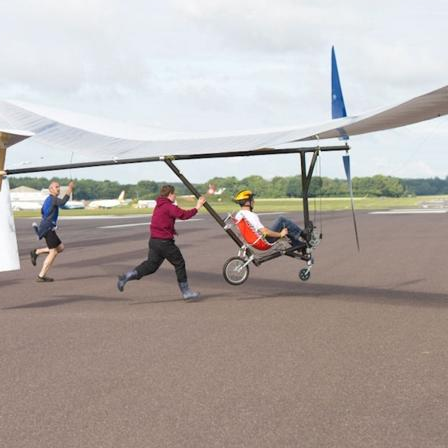

In [292]:
display(to_PILImage(denorm(img)))

In [211]:
from inpaint.utils import random_ff_mask, random_bbox_mask

In [212]:
C, H, W = img.shape
C, H, W

(3, 448, 448)

In [293]:
mask_path = '../samples/test/mask/3_mask.jpg'
if platform.system().lower() == 'windows':
    mask_path = '..\samples\test\mask\3_mask.jpg'
    
mask = cv2.imread(mask_path)
mask.shape

(512, 768, 3)

In [294]:
y, x, _ = mask.shape

In [295]:
cropx = 448
cropy = 448
startx = x//2-(cropx//2)
starty = y//2-(cropy//2)  

In [296]:
mask = mask[starty:starty+cropy,startx:startx+cropx]
mask.shape

(448, 448, 3)

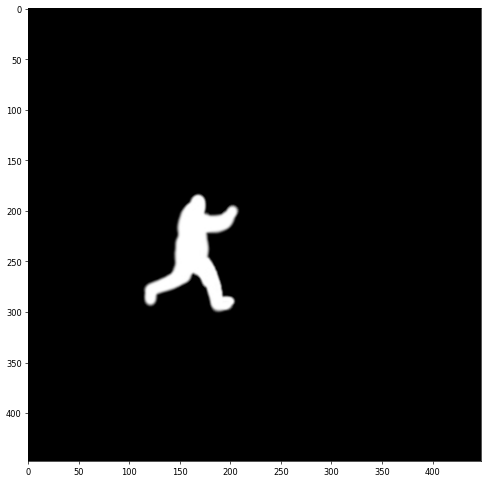

In [297]:
plt.figure(figsize=(20,10), dpi=60)
plt.imshow(mask)

In [302]:
mask = mask[:,:,:1]
mask = np.transpose(mask, (2,0,1))
mask[np.where(mask<=100)] = 0
mask[np.where(mask>100)] = 1

(448, 448, 1)

In [303]:
img.shape, mask.shape

(1, 448, 448)

In [307]:
masked_img = denorm(img) * (1 - mask) + mask
masked_img.shape

torch.Size([3, 448, 448])

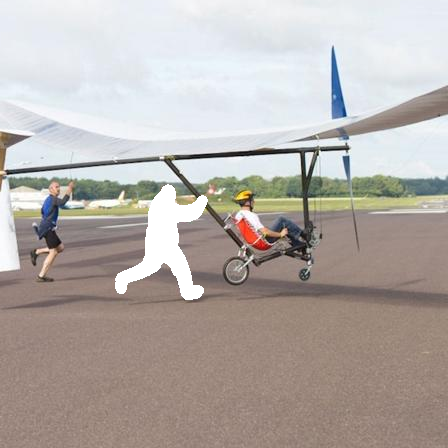

In [308]:
display(to_PILImage(masked_img))

In [309]:
type(img), type(mask)

(torch.Tensor, numpy.ndarray)

___

1. load generator from best model checkpoint


In [268]:
from inpaint.core.generator import GatedGenerator

In [275]:
args = {}

# model | generator config
args["--in_channels"] = 4
args["--out_channels"] = 3
args["--latent_channels"] = 64
args["--pad_type"] = "zero"
args["--activation"] = "elu"
args["--norm_d"] = "none"
args["--norm_g"] = "batch"
args["--init_type"] = "kaiming"
args["--init_gain"] = 0.02
args["--use_cuda"] = True
args["--use_perceptualnet"] = True
args["--sn_enable"] = True
args["--add_context_attention"] = True

In [276]:
cfg = create_cfg(args)

In [318]:
generator = GatedGenerator(cfg)

ckpt_path = "../../../experiments/inpaint/ckpts/exp7/best_models_final.pth"

models = torch.load(ckpt_path, map_location=torch.device('cpu'))
gen_model_state_dict = models["generator_state_dict"]

generator.load_state_dict(gen_model_state_dict)

<All keys matched successfully>

___
2. pass generator, img and mask to predict method
   img shape (3, H, W) and mask shape (1, H, W)

In [319]:
from inpaint.tools import predict

In [320]:
output = predict(generator, img, torch.from_numpy(mask.astype(np.float32)))

___
3. Visualize predicted image

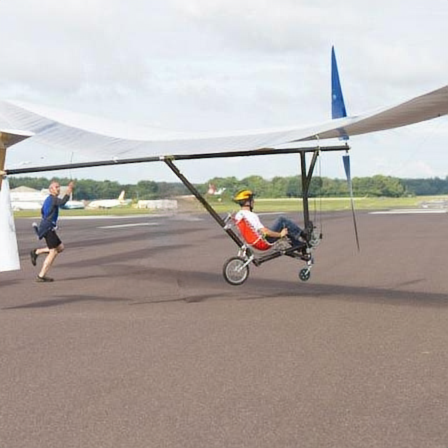

In [321]:
display(to_PILImage(output))